In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("GPS_dataset.csv")
df.head()

,Unnamed: 0,Longitude,Latitude,Altitude,Time,Actual_Speed,Time_diff,Pred_Lat,Pred_Lon,Haversine_Distance,Calculated_Speed
0,0,-105.434187,41.233283,2606.7,2014-07-26 13:03:55+00:00,2.776280,1.0,41.233209,-105.434177,0.000000,0.000000
1,1,-105.434177,41.233209,2607.6,2014-07-26 13:03:58+00:00,1.513981,3.0,41.233247,-105.434183,8.270818,2.756939
2,2,-105.434183,41.233247,2607.2,2014-07-26 13:04:15+00:00,0.777868,17.0,41.233218,-105.434231,4.255097,0.250300
3,3,-105.434231,41.233218,2608.0,2014-07-26 13:04:19+00:00,1.334299,4.0,41.233196,-105.434269,5.148746,1.287187
4,4,-105.434269,41.233196,2608.8,2014-07-26 13:04:22+00:00,1.160302,3.0,41.233253,-105.434293,4.010212,1.336737


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19828 entries, 0 to 19827
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          19828 non-null  int64  
 1   Longitude           19828 non-null  float64
 2   Latitude            19828 non-null  float64
 3   Altitude            19828 non-null  float64
 4   Time                19828 non-null  object 
 5   Actual_Speed        19828 non-null  float64
 6   Time_diff           19828 non-null  float64
 7   Pred_Lat            19828 non-null  float64
 8   Pred_Lon            19828 non-null  float64
 9   Haversine_Distance  19828 non-null  float64
 10  Calculated_Speed    19828 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


In [4]:
df['location_error'] = np.sqrt((df['Latitude'] - df['Pred_Lat'])**2 + (df['Longitude'] - df['Pred_Lon'])**2)
df['acceleration'] = df['Actual_Speed'].diff() / df['Time_diff'].replace(0, np.nan)
df['stop_flag'] = (df['Calculated_Speed'] < 1).astype(int)

In [5]:
features = pd.DataFrame()
features['avg_speed'] = df['Actual_Speed'].rolling(5).mean()
features['std_speed'] = df['Actual_Speed'].rolling(5).std()
features['avg_distance'] = df['Haversine_Distance'].rolling(5).mean()
features['avg_time_diff'] = df['Time_diff'].rolling(5).mean()
features['avg_location_error'] = df['location_error'].rolling(5).mean()
features['avg_acceleration'] = df['acceleration'].rolling(5).mean()
features['stop_rate'] = df['stop_flag'].rolling(5).mean()

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19828 entries, 0 to 19827
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   avg_speed           19824 non-null  float64
 1   std_speed           19824 non-null  float64
 2   avg_distance        19824 non-null  float64
 3   avg_time_diff       19824 non-null  float64
 4   avg_location_error  19824 non-null  float64
 5   avg_acceleration    19823 non-null  float64
 6   stop_rate           19824 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [7]:
features = features.dropna()

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

In [10]:
features['cluster'] = labels

In [11]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

features['x'] = X_tsne[:, 0]
features['y'] = X_tsne[:, 1]

c:\Users\fayzi-dev\Desktop\_Projects\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


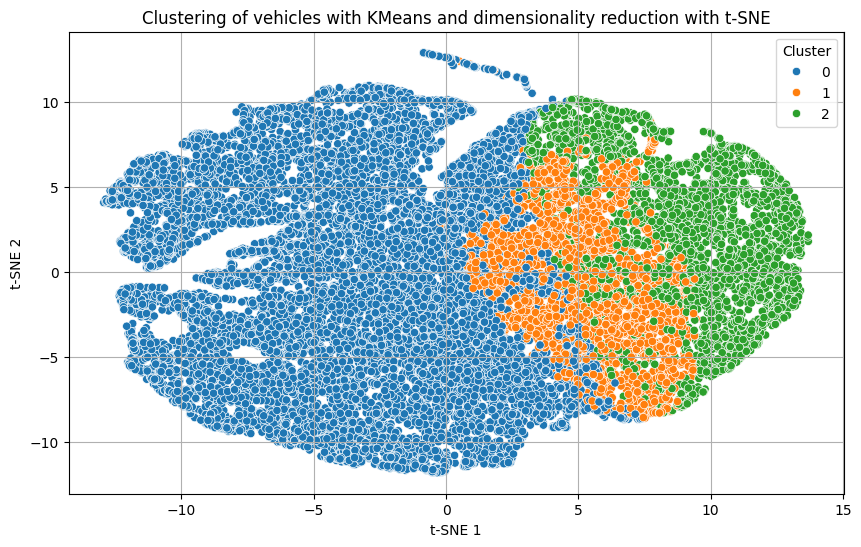

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='x', y='y', hue='cluster', palette='tab10')
plt.title('Clustering of vehicles with KMeans and dimensionality reduction with t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

| خوشه | تفسیر احتمالی                                        |
| ---- | ---------------------------------------------------- |
| 0    | رفتار نرمال خودروها (سرعت پایدار، دقت مکان خوب)      |
| 1    | رفتار نیمه‌نرمال (تغییر سرعت یا توقف‌های متوسط)      |
| 2    | رفتار غیرعادی (شتاب بالا، توقف زیاد، خطای مکان بالا) |
